# Visualizing and Evaluating GRU Autoencoder

In [27]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from GRU_Autoencoder import GRUAutoencoder
from pathlib import Path
import os
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

## Raw Model :
### We will try to predict anomalies in Slaesforce stock data.


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GRUAutoencoder().to(device)

model_path = Path("../../models/gru/GRU_autoencoder.pth")
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# Load the data
data = pd.read_csv("../../data/sequences_ready/CRM_data_sequences.csv")
data = data.values.reshape(-1, 30, 5)
tensor_data = torch.tensor(data, dtype=torch.float32)

In [29]:
model.eval()
with torch.no_grad():
    output = model(tensor_data.to(device)).cpu().numpy()

# Plot the results
reconstructed_close = output[:, -1, 0]
real_close = tensor_data[:, -1, 0].numpy()

# RMSE
reconstruction_error = (real_close - reconstructed_close) ** 2

In [30]:
# Original data for datetime
original_data = pd.read_csv("../../data/processed_data/CRM_data.csv")
dates = pd.to_datetime(original_data["Date"], utc=True)

aligned_dates = dates[29:29 + len(tensor_data)].reset_index(drop=True)

In [31]:
# 5% threshold for anomalies
threshold = np.percentile(reconstruction_error, 97)
anomalies = reconstruction_error > threshold

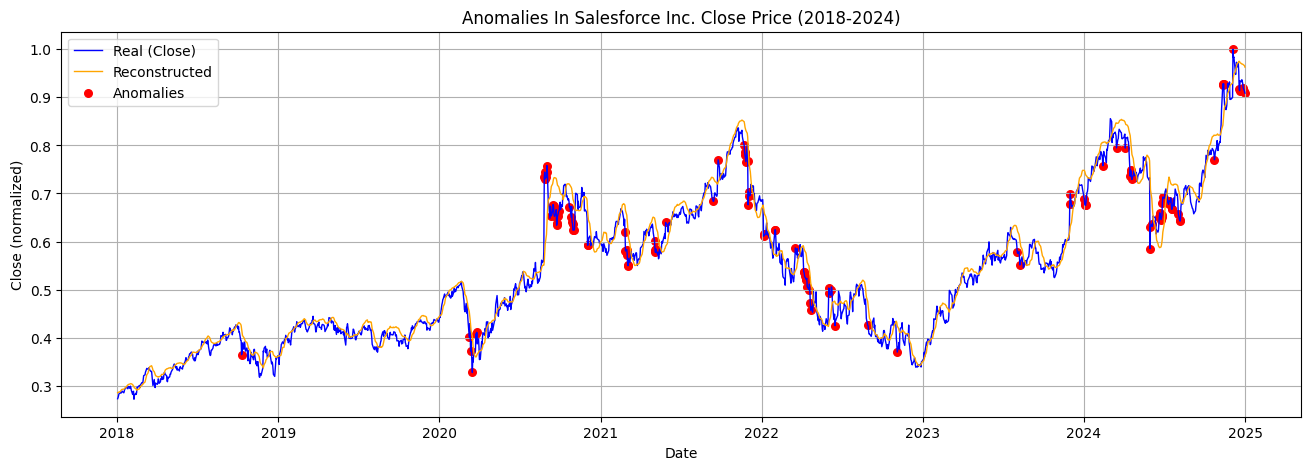

In [32]:
# Which years to plot
start_year = 2018
end_year = 2024

mask = (aligned_dates.dt.year >= start_year) & (aligned_dates.dt.year <= end_year)

plot_dates = aligned_dates[mask]
plot_real_close = real_close[mask]
plot_reconstructed_close = reconstructed_close[mask]

plt.figure(figsize=(16, 5))

plt.plot(plot_dates, plot_real_close, label="Real (Close)", color='blue', linewidth=1)
plt.plot(plot_dates, plot_reconstructed_close, label="Reconstructed", color='orange', linewidth=1)

plt.scatter(
    plot_dates[anomalies[mask]],
    plot_real_close[anomalies[mask]],
    color='red',
    marker='o',
    s=30,
    label="Anomalies"
)

plt.title(f"Anomalies In Salesforce Inc. Close Price ({start_year}-{end_year})")
plt.xlabel("Date")
plt.ylabel("Close (normalized)")
plt.legend()
plt.grid()
plt.show()


In [33]:
print(f"Reconstruction error: {reconstruction_error.mean()}")

Reconstruction error: 0.0002992012014146894


## Training The Model with Salesforce Data

In [34]:
dataset = TensorDataset(tensor_data)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [35]:
# Redefining optimizer
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)
criterion = nn.MSELoss()

In [36]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5)

In [37]:
# Fine-tuning the model
for epoch in range(5):  # pocas épocas
    model.train()
    total_loss = 0
    for batch in dataloader:
        batch = batch[0].to(device)
        output = model(batch)
        loss = criterion(output, batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(dataloader)
    scheduler.step(avg_loss)
    print(f"[Fine-tune] Epoch {epoch+1}, Loss: {total_loss / len(dataloader):.6f}")


[Fine-tune] Epoch 1, Loss: 0.000625
[Fine-tune] Epoch 2, Loss: 0.000612
[Fine-tune] Epoch 3, Loss: 0.000611
[Fine-tune] Epoch 4, Loss: 0.000611
[Fine-tune] Epoch 5, Loss: 0.000611


### Ploting The Results

In [38]:
model.eval()
with torch.no_grad():
    output = model(tensor_data.to(device)).cpu().numpy()

# Plot the results
reconstructed_close = output[:, -1, 0]
real_close = tensor_data[:, -1, 0].numpy()

# RMSE
reconstruction_error = (real_close - reconstructed_close) ** 2

In [39]:
# 5% threshold for anomalies
threshold = np.percentile(reconstruction_error, 97)
anomalies = reconstruction_error > threshold

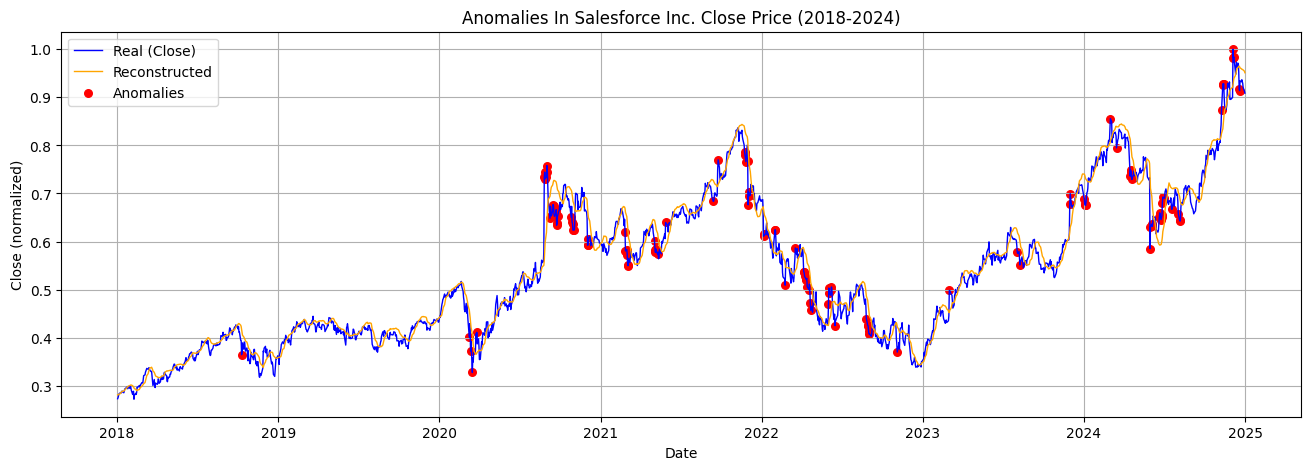

In [40]:
# Which years to plot
start_year = 2018
end_year = 2024

mask = (aligned_dates.dt.year >= start_year) & (aligned_dates.dt.year <= end_year)

plot_dates = aligned_dates[mask]
plot_real_close = real_close[mask]
plot_reconstructed_close = reconstructed_close[mask]

plt.figure(figsize=(16, 5))

plt.plot(plot_dates, plot_real_close, label="Real (Close)", color='blue', linewidth=1)
plt.plot(plot_dates, plot_reconstructed_close, label="Reconstructed", color='orange', linewidth=1)

plt.scatter(
    plot_dates[anomalies[mask]],
    plot_real_close[anomalies[mask]],
    color='red',
    marker='o',
    s=30,
    label="Anomalies"
)

plt.title(f"Anomalies In Salesforce Inc. Close Price ({start_year}-{end_year})")
plt.xlabel("Date")
plt.ylabel("Close (normalized)")
plt.legend()
plt.grid()
plt.show()


In [41]:
print(f"Reconstruction error: {reconstruction_error.mean()}")

Reconstruction error: 0.00024313636822625995
